# Explicabilidad

En este notebook vamos a realizar algunos pasos de lo que comprende la fase de explicabilidad en un modelo, sin entrar mucho en profundidad debido a la complejidad de esta parte, pero intentando abarcar los más importante que se puede hacer y que sea lo más completo y sencillo posible

## Librerías

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocesamiento y modelado
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import lightgbm

# Métricas y validación
from sklearn.metrics import (balanced_accuracy_score, average_precision_score, 
                             precision_recall_curve, roc_curve, auc, recall_score, 
                             precision_score, confusion_matrix, classification_report, 
                             silhouette_score, roc_auc_score, f1_score,make_scorer, 
                             accuracy_score, fbeta_score, ConfusionMatrixDisplay)

# Rebalanceo de clases
from imblearn.under_sampling import RandomUnderSampler

# Eliminado el import de eli5 ya que no se utiliza en el código proporcionado

#from eli5.sklearn import PermutationImportance
# from helpers import convert_to_lime_format
# rom lime.lime_tabular import LimeTabularExplainer
# pip install scikit-learn==0.24.2  # Ejemplo de versión, ajusta según sea necesario


# Dataset 

In [2]:
pd_fraude_train_t = pd.read_csv('./data/pd_train_best_param.csv')
pd_fraude_test = pd.read_csv('./data/pd_test_best_param.csv')

Observamos de nuevo los tipos de datos que nos encontramos

# Separamos en train, test el dataset

In [4]:
X_train = pd_fraude_train_t.drop(columns=['Unnamed: 0', 'fraud_bool'])
y_train = pd_fraude_train_t['fraud_bool']
X_test = pd_fraude_test.drop(columns=['Unnamed: 0', 'fraud_bool'])
y_test = pd_fraude_test['fraud_bool']


# Modelo LightGBM elegido

In [5]:
rs_02 = RandomUnderSampler(random_state=33, sampling_strategy=0.2)

In [6]:
X_train_rs_02, y_train_rs_02 = rs_02.fit_resample(pd_fraude_train_t.drop(columns=['Unnamed: 0', 'fraud_bool']),
                                                          pd_fraude_train_t['fraud_bool'])

In [7]:
X_train_rs_02.shape

(52938, 42)

Realizamos el preprocesamiento previo del modelo

In [10]:
%%time

lgb_classifier_02 = LGBMClassifier(objective='binary', random_state=33)

param_dist = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [150, 200, 250, 300, 350, 400],
    'num_leaves': [20, 40, 60, 80, 100],
    'max_depth': [3, 7, 12, 16, 20, 25],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30, 40, 50]
}

f2_score = make_scorer(fbeta_score, beta=2)

random_search = RandomizedSearchCV(
    estimator=lgb_classifier_02,
    param_distributions=param_dist,
    n_iter=100,
    scoring=f2_score,
    cv=5,
    verbose=2,
    random_state=33,
    n_jobs=-1
)

random_search.fit(X_train_rs_02, y_train_rs_02)

best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Number of positive: 8823, number of negative: 44115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3038
[LightGBM] [Info] Number of data points in the train set: 52938, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [11]:
print(X_train_rs_02.shape, X_test.shape)

(52938, 42) (200000, 42)


In [12]:
from lightgbm import LGBMClassifier

# Create an instance of LGBMClassifier with the provided parameters
light_gbm = LGBMClassifier(subsample=0.8, 
                           num_leaves=100, 
                           n_estimators=400, 
                           min_child_samples=10,
                           max_depth=3, 
                           learning_rate=0.3, 
                           colsample_bytree=1.0)

# Training the classifier with training data
light_gbm.fit(X_train_rs_02, y_train_rs_02)

# Predict the labels for the test dataset
y_pred_light_gbm = light_gbm.predict(X_test)


[LightGBM] [Info] Number of positive: 8823, number of negative: 44115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3038
[LightGBM] [Info] Number of data points in the train set: 52938, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [13]:
accuracy_light_gbm = accuracy_score(y_test, y_pred_light_gbm)
recall_light_gbm = recall_score(y_test, y_pred_light_gbm)
precision_light_gbm = precision_score(y_test, y_pred_light_gbm)
f1_light_gbm = f1_score(y_test, y_pred_light_gbm)
f2_light_gbm = fbeta_score(y_test, y_pred_light_gbm, beta=2)
matriz_confusion_light_gbm = confusion_matrix(y_test, y_pred_light_gbm)
print("Light GBM")
print("Accuracy score: %.3f" % accuracy_light_gbm)
print("Recall score: %.3f" % recall_light_gbm)
print("Precision score: %.3f" % precision_light_gbm)
print("F1 score: %.3f" % f1_light_gbm)
print("F2 score: %.3f" % f2_light_gbm)
print("Matriz de confusión:", matriz_confusion_light_gbm)

Light GBM
Accuracy score: 0.950
Recall score: 0.510
Precision score: 0.112
F1 score: 0.184
F2 score: 0.298
Matriz de confusión: [[188883   8911]
 [  1082   1124]]


Sacamos la informacion sobre nuestro modelo elegido

In [18]:

model = light_gbm.fit(X_train, y_train)

pd_train_predicted = pd.DataFrame(model.predict_proba(X_train), 
                                index=X_train.index, columns = ['y_predicted_0', 'y_predicted']).drop(['y_predicted_0'],axis=1)
pd_train_predicted_final = pd.concat([X_train, pd_train_predicted, y_train],axis=1)

pd_test_predicted = pd.DataFrame(model.predict_proba(X_test), 
                                 index=X_test.index, columns = ['y_predicted_0', 'y_predicted']).drop(['y_predicted_0'],axis=1)
pd_test_predicted_final = pd.concat([X_test, pd_test_predicted, y_test],axis=1)

[LightGBM] [Info] Number of positive: 8823, number of negative: 44115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3038
[LightGBM] [Info] Number of data points in the train set: 52938, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

# 3.1 Curvas PRC

In [19]:
def plot_prc(y, y_predicted, ax, name_title, titlesize=30, other_size=12):
    """
    Plots the Precision-Recall Curve (PRC) for classification models.

    Parameters:
    y: True values of the target variable.
    y_predicted: Values predicted by the model.
    ax: Axis of matplotlib for the graph.
    name_title: Title of the graph.
    titlesize: Size of the title.
    other_size: Size of other chart elements (labels, legends, etc.).

    Realize:
    - Configures the font style and size of the graph.
    - Calculates and plots the PRC curve.
    - Draws a line representing the unskilled model.
    - Adds captions and labels.
    """
    import matplotlib
    from sklearn.metrics import average_precision_score, precision_recall_curve

    # Setting the style of the chart.
    matplotlib.rc('font', size=other_size)
    matplotlib.rc('axes', titlesize=titlesize)
    matplotlib.rc('axes', labelsize=other_size)
    matplotlib.rc('ytick', labelsize=other_size)
    matplotlib.rc('legend', fontsize=other_size)
    matplotlib.rc('figure', titlesize=other_size)
    matplotlib.rc('xtick', labelsize=other_size)

    # Calculation of average accuracy.
    average_precision = average_precision_score(y, y_predicted)

    # Calculation of the PRC curve.
    lr_precision, lr_recall, _ = precision_recall_curve(y, y_predicted)
    
    plt.ylim([0,1])
    no_skill = len(y[y == 1]) / len(y)
    ax.plot([0,1], [no_skill, no_skill], linestyle='--')
    ax.plot(lr_recall, lr_precision, marker='.')
    ax.set_title('PRC_' + str(name_title) + '_' + str(round(average_precision, 2)))
    ax.set_ylim([0, 1.01])
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')


Llamamos a una función, para realizar las curvas PRC 

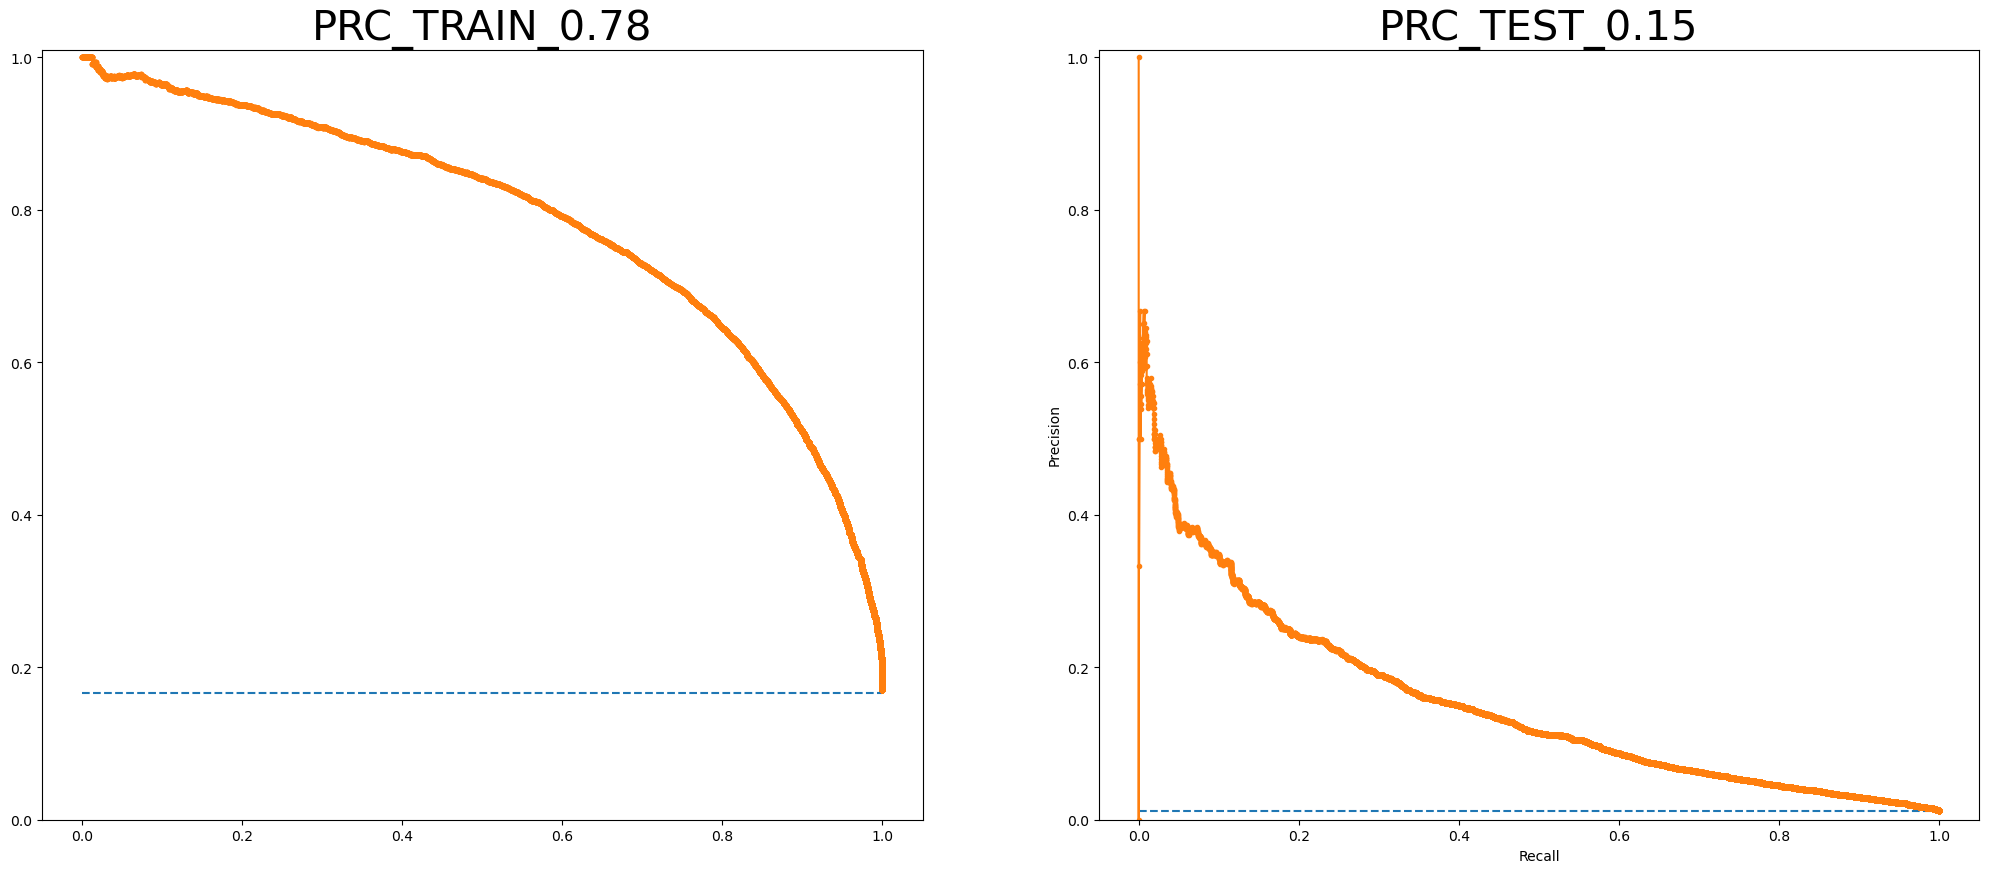

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,10))
plot_prc(pd_train_predicted_final.fraud_bool, pd_train_predicted_final.y_predicted,ax1,'TRAIN')
plot_prc(pd_test_predicted_final.fraud_bool, pd_test_predicted_final.y_predicted,ax2,'TEST')

En un contexto desbalanceado, la curva PRC es a menudo más informativa que la curva ROC, dado que observamos la capacidad del modelo para predecir la clase minoritaria, mucho mejor.

Podemos observar que el modelo sí que se encuentra sobreentrenado, dado que las formas no coinciden entre sí, pese a la realización de técnicas de regularización, como lasso. Por lo tanto, consideramos necesario la aplicación de un early stopping o similar, para reducir el sobreentrenamiento.

# 4 Elección del mejor corte

In [21]:
%%time
# Measure the time it takes to run the code

# Get the predicted probabilities of the target variable
prob_predictions = pd_train_predicted_final.y_predicted.values

# Create an empty list to store recall and precision values for different thresholds
recall_precision = []

# Iterate over a range of thresholds from 0.01 to 0.99 with a step of 0.01
for threshold in np.arange(0.01, 0.99, 0.01):
    
    # Apply the threshold to the predicted probabilities
    given_threshold = [1 if value > threshold else 0 for value in prob_predictions]
    
    # Calculate recall and precision scores for the given threshold
    recall = recall_score(pd_train_predicted_final.fraud_bool, given_threshold)
    precision = precision_score(pd_train_predicted_final.fraud_bool, given_threshold)
    
    # Append the threshold, recall, and precision values to the list
    recall_precision.append([threshold, recall, precision])


CPU times: total: 14.1 s
Wall time: 15.6 s


In [40]:
import numpy as np

def plot_recall_precision(recall_precision):
    # Create a function to plot recall and precision values
    
    plt.figure(figsize=(15, 5))  # Set the size of the plot
    
    # Round the threshold values to four decimal places
    threshold_values = np.around([element[0] for element in recall_precision], decimals=4)
    
    # Create a point plot for recall values in red
    ax = sns.pointplot(x=threshold_values, y=[element[1] for element in recall_precision],
                       color="r", label='recall', scale=1)
    
    # Create a point plot for precision values in blue
    ax = sns.pointplot(x=threshold_values, y=[element[2] for element in recall_precision],
                       color="b", label='precision')
    
    # Set the title of the plot
    ax.set_title('recall-precision versus threshold')
    
    # Set the labels for the x and y axes
    ax.set_xlabel('threshold')
    ax.set_ylabel('probability')
    
    labels = ax.get_xticklabels()
    
    # Customize the x-axis labels by skipping some of them for better readability
    for i, l in enumerate(labels):
        if(i % 5 == 0) or (i % 5 == 1) or (i % 5 == 2) or (i % 5 == 3):
            labels[i] = ''  # skip even labels
            ax.set_xticklabels(labels, rotation=45, fontdict={'size': 10})
    
    plt.show()  # Display the plot


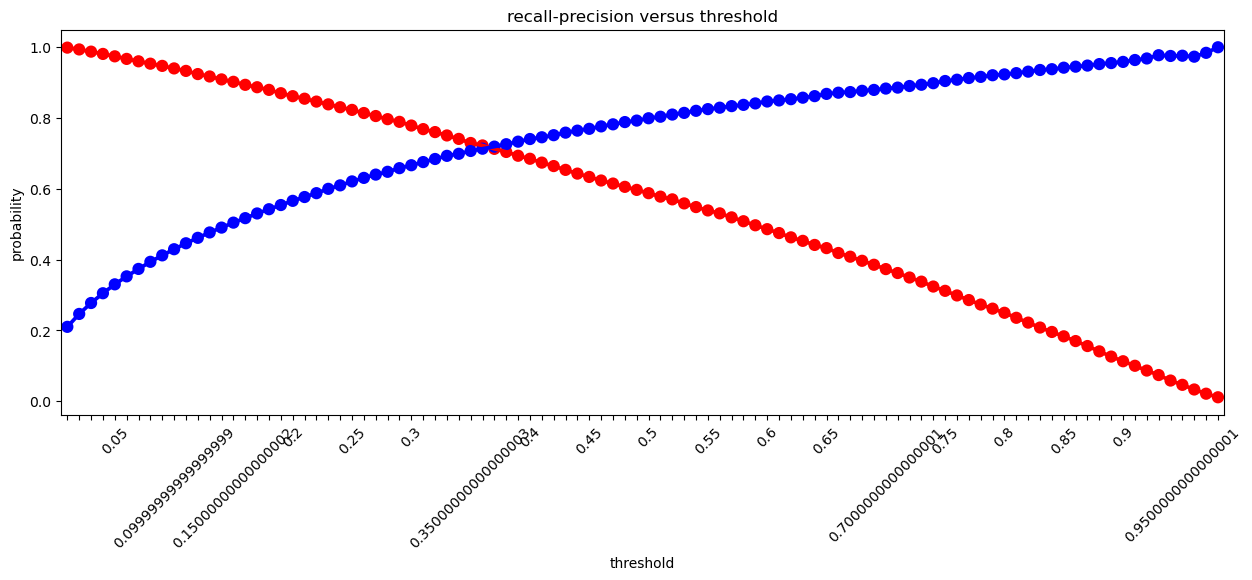

In [41]:
plt.rcParams.update(plt.rcParamsDefault)
plot_recall_precission(recall_precision)

El gráfico creado por este código muestra la relación entre dos métricas de rendimiento de un modelo de clasificación: la recuperación (recall) y la precisión (precision). Estas métricas se muestran en función de diferentes valores de umbral (threshold) que se aplican al modelo para tomar decisiones de clasificación.

La recuperación (recall) es una métrica que representa la proporción de ejemplos positivos que fueron correctamente identificados por el modelo. En otras palabras, mide la capacidad del modelo para capturar todos los casos positivos. Un valor alto de recall indica que el modelo está identificando la mayoría de los casos positivos.

La precisión (precision), por otro lado, es una métrica que representa la proporción de ejemplos identificados como positivos por el modelo que son verdaderos positivos. En otras palabras, mide cuán preciso es el modelo al etiquetar los casos como positivos. Un valor alto de precisión indica que el modelo tiende a hacer predicciones positivas correctas.

El gráfico muestra cómo cambian la recuperación y la precisión a medida que se varía el umbral de decisión del modelo. A menudo, existe un compromiso (trade-off) entre estas dos métricas: cuando se aumenta el umbral para hacer predicciones positivas, la precisión tiende a aumentar, pero la recuperación tiende a disminuir, y viceversa.

Este tipo de gráfico es útil para entender cómo se comporta un modelo en función de diferentes umbrales y para ayudar a tomar decisiones sobre el umbral óptimo, dependiendo de las necesidades específicas del problema. Por ejemplo, en casos en los que es crucial identificar todos los casos positivos, es posible que se prefiera un umbral más bajo para maximizar la recuperación, aunque a costa de una menor precisión. Por otro lado, en casos en los que la precisión es fundamental, se podría elegir un umbral más alto para aumentar la precisión, aunque a costa de una menor recuperación.

# 4.1 Matrices de confusión

In [26]:
def binary_target(x):
    if x<=0.09:
        y=0
    else:
        y=1
    return y

pd_train_predicted_final = pd_train_predicted_final\
                            .assign(binary_y_predicted = pd_train_predicted_final['y_predicted'].apply(binary_target))

pd_test_predicted_final = pd_test_predicted_final\
                            .assign(binary_y_predicted = pd_test_predicted_final['y_predicted'].apply(binary_target)) 


Convertimos un valor numérico a una etiqueta binaria basada en un umbral. En este caso, el umbral está fijado en 0.09. La función retorna 0 si el valor x es menor o igual a 0.09, y retorna 1 si el valor x es mayor que 0.09.

Esto transforma probabilidades continuas (como las que se obtienen de modelos logísticos, árboles de decisión, etc.) en etiquetas de clase binarias (0 o 1). Esto es útil cuando se necesitan decisiones claras de clasificación en lugar de probabilidades.

Establecimiento de un Umbral Específico, en una situación donde los falsos negativos son más costosos que los falsos positivos, se podría optar por un umbral más bajo para ser más inclusivos al identificar la clase positiva.

In [27]:
pd_train_predicted_final.head()

,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_24h,velocity_4w,bank_branch_count_8w,...,housing_status_BE,housing_status_BF,housing_status_BG,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,y_predicted,fraud_bool,binary_y_predicted
0,1.331665,-0.402204,-0.482362,-1.139290,-0.189647,-0.469984,1.769967,-0.224860,-0.472631,-0.381165,...,-0.451114,-0.041205,-0.015694,4.193935,-0.721586,-0.598569,-0.085509,0.046778,0,0
1,0.225649,-0.402204,-0.561521,-0.307489,-0.188467,-0.449193,-0.623504,-0.457312,-1.339275,-0.039020,...,-0.451114,-0.041205,-0.015694,-0.238440,-0.721586,1.670651,-0.085509,0.010649,0,0
2,0.951794,-0.402204,0.128295,0.524312,-0.184786,0.739937,-0.608583,-1.229187,-1.073096,-0.365910,...,2.216737,-0.041205,-0.015694,-0.238440,-0.721586,-0.598569,-0.085509,0.138746,0,1
3,0.323364,-0.402204,-0.312735,0.524312,-0.188676,-0.481514,-0.437478,-0.497580,0.184297,3.574202,...,-0.451114,-0.041205,-0.015694,-0.238440,-0.721586,1.670651,-0.085509,0.524831,0,1
4,-0.791140,1.345809,-0.742456,0.524312,-0.185928,2.149605,-0.547900,-1.517218,-1.935850,-0.398599,...,-0.451114,-0.041205,-0.015694,-0.238440,-0.721586,-0.598569,-0.085509,0.002018,0,0


In [28]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):   
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

Llamamos a una función, para realizar las diferentes matrices de confusion

# 5 parte a realizar

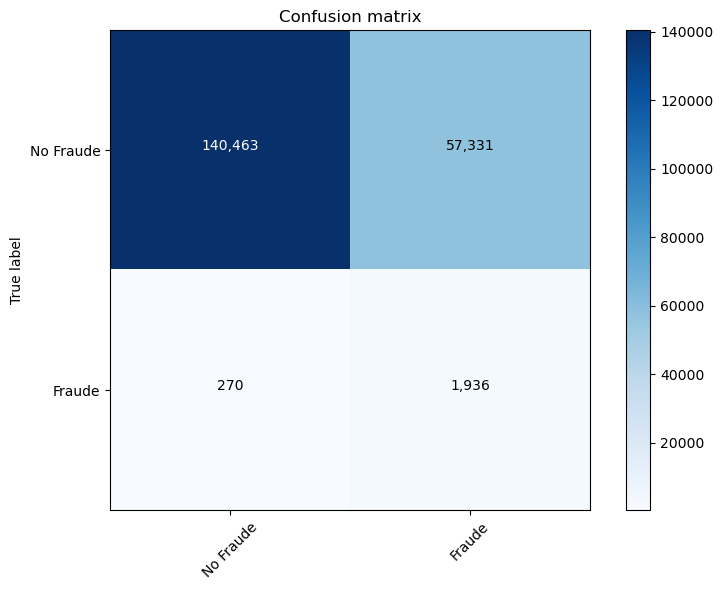

In [32]:
import itertools

# Resto de tu código aquí

cm = confusion_matrix(pd_test_predicted_final.fraud_bool.values,
                      pd_test_predicted_final.binary_y_predicted.values)
plot_confusion_matrix(cm,target_names=['No Fraude', 'Fraude'],
                      title='Confusion matrix',
                      cmap=None, normalize=False)

Vemos el número total de los valores dentro de la matriz de onfusion, esto nos permite ver cuantos y cuantos no predice correctamente 

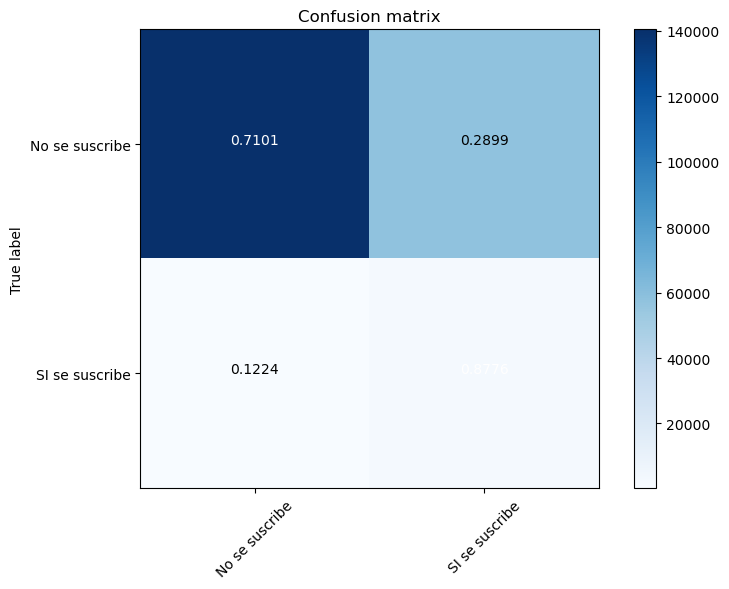

In [42]:
cm = confusion_matrix(pd_test_predicted_final.fraud_bool.values,
                      pd_test_predicted_final.binary_y_predicted.values)
plot_confusion_matrix(cm,target_names=['No se suscribe', 'SI se suscribe'],
                      title='Confusion matrix',
                      cmap=None, normalize=True)

Esto nos permite ver mas claramente, que tan bueno predice cada parte de la matriz de confusion, por ejemplo solamente capta un 12% de los falsos negativos

## Método SHAP

In [44]:
import shap
# Need to load JS vis in the notebook
shap.initjs() 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


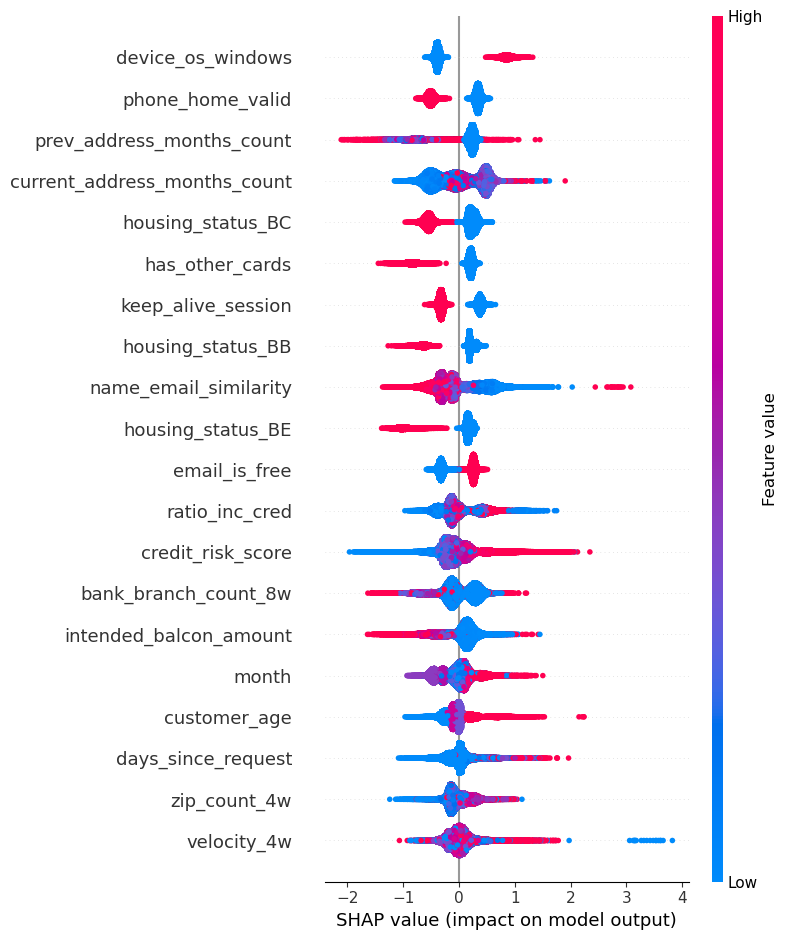

CPU times: total: 2min 57s
Wall time: 1min 2s


In [45]:
%%time
explainer = shap.TreeExplainer(model)# esto se aplica al trading de arboles, es el mas rapido para los arboles
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

"Podemos ver que existe mucha variabilidad y mezcla dentro del dataset. Encontramos variables como "email_is_free" que se encuentra claramente diferenciada y contribuye de forma positiva al dataset, y luego tenemos la variable "name_email_similarity," la cual es mucho más compleja y contribuye en su mayor parte negativamente al dataset, dado que su valor rojo se encuentra a la izquierda.

Como hemos comentado, existe una gran heterogeneidad dentro de las variables. Sin embargo, encontramos que la mayoría tienen al menos algo de correlación negativa con el modelo en lugar de una correlación positiva.

Asimismo, aquellas variables que tienen su concentración más cercana al 0 son aquellas que tienen más valores que afectan menos al dataset.

Este tipo de gráfico nos permite saber qué efecto han tenido cada variable en el output general del , de una forma muy eficaz, tenemos tanto si afectan positiva como negativamente al modelo, como en que medidadelo."delo.


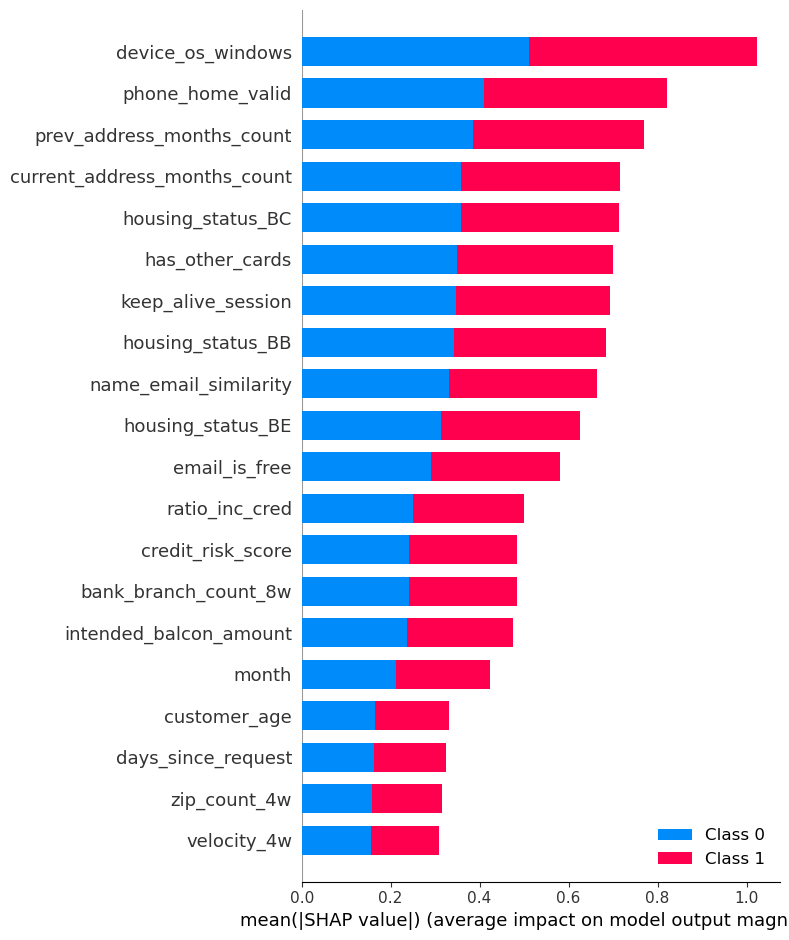

In [50]:
shap.summary_plot(shap_values, X_test)

Aqui podemos ver al improtancia que ha tenido cada variable para el modelo, de una forma mas clara y al punto que la anterior. El color azul, seria la importancia para predecir el no fraude, mientras que el rojo su importancia para predcir el fraude.

Podemos ver que la variable de "device_os_windows" a sido la mas importante, tanto para el fraude como para el no fraude en este modelo. Seguida de "phone_home_valid"

In [51]:
shap.force_plot(explainer.expected_value[1], shap_values[1][888,:], X_test.iloc[888,:], link='logit')

In [52]:
shap.force_plot(explainer.expected_value[1], shap_values[1][400,:], X_test.iloc[400,:], link='logit')

Además, también se pueden realizar gráficos de dependencia parcial

### SHAP + LIGHTGBM

In [53]:
%%time
pd_shap = pd.DataFrame(model.predict_proba(X_test, pred_contrib=True), 
                       columns=list(X_test.columns)+['other']).drop(['other'],axis=1)

CPU times: total: 1min 42s
Wall time: 33.2 s


In [55]:
pd_contrib.head(10)

,contrib1_max1,contrib1_max2,contrib1_max3,contrib0_max1,contrib0_max2,contrib0_max3
0,0,0,0,0,0,0
0,employment_status_CB,current_address_months_count,housing_status_BC,phone_home_valid,bank_branch_count_8w,prev_address_months_count
0,email_is_free,name_email_similarity,phone_home_valid,device_os_windows,credit_risk_score,bank_branch_count_8w
0,ratio_inc_cred,phone_home_valid,housing_status_BB,device_os_windows,customer_age,days_since_request
0,current_address_months_count,housing_status_BB,prev_address_months_count,device_os_windows,phone_home_valid,email_is_free
0,name_email_similarity,device_os_windows,bank_branch_count_8w,month,keep_alive_session,phone_home_valid
0,bank_branch_count_8w,email_is_free,has_other_cards,days_since_request,credit_risk_score,device_os_windows
0,ratio_inc_cred,housing_status_BB,name_email_similarity,device_os_windows,current_address_months_count,phone_home_valid
0,housing_status_BC,current_address_months_count,has_other_cards,device_os_windows,bank_branch_count_8w,keep_alive_session
0,prev_address_months_count,employment_status_CB,housing_status_BE,device_os_windows,days_since_request,name_email_similarity


# Conclusion

## Análisis del Modelo de Machine Learning

### Identificación del Sobreajuste
Podemos observar que nuestro modelo presenta un **sobreajuste (overfitting)** significativo, lo cual es un aspecto importante a corregir en el futuro. El sobreajuste indica que, aunque el modelo tiene un rendimiento excepcional con los datos de entrenamiento, su eficacia disminuye considerablemente al enfrentarse a datos nuevos o de prueba. Esto sugiere la necesidad de revisar aspectos como la complejidad del modelo, la cantidad de datos de entrenamiento, o la aplicación de técnicas de regularización.

### Evaluación de Métricas: Precisión, Recall y Puntuación F1
A pesar del sobreajuste, las métricas de evaluación del modelo, como la **precisión**, el **recall** y la **puntuación F1**, indican un rendimiento aceptable. Estas métricas son fundamentales para comprender cómo el modelo gestiona la clasificación de las diferentes clases y cómo equilibra los errores de tipo I (falsos positivos) y tipo II (falsos negativos).

### Análisis de la Curva Umbral vs Precisión
Al analizar la curva que relaciona el **umbral (threshold) con la precisión**, notamos que se estabiliza alrededor de **0.3**. Esto sugiere que ajustar el umbral de decisión a este valor podría optimizar el equilibrio entre la precisión y el recall del modelo, especialmente en contextos donde evitar falsos positivos es crucial.

### Aplicación de SHAP para la Interpretación de Variables
Finalmente, hemos utilizado **SHAP (SHapley Additive exPlanations)** para determinar la importancia específica de cada variable en el modelo. Esta técnica avanzada, basada en la teoría de juegos, descompone las predicciones del modelo en sumas de efectos atribuibles a cada variable. Este análisis es extremadamente útil para futuras selecciones de variables o ajustes en otros modelos, ya que nos proporciona una comprensión profunda de la importancia relativa y el impacto de cada variable en las predicciones del modelo.
